# Tennis Solution

In [1]:
from unityagents import UnityEnvironment

import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from ddpg_agent import Agent

In [2]:
env = UnityEnvironment(file_name="Tennis_Linux/Tennis.x86_64", no_graphics=True)

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24


In [3]:
agent = Agent(state_size=state_size, action_size=action_size, num_agents=num_agents, random_seed=10)

Episode 100	Episode Score: 0.000000	Avg. Score: 0.008500	t:   13
Episode 200	Episode Score: 0.100000	Avg. Score: 0.028200	t:   33
Episode 300	Episode Score: 0.000000	Avg. Score: 0.042500	t:   14
Episode 400	Episode Score: 0.000000	Avg. Score: 0.038400	t:   14
Episode 500	Episode Score: 0.000000	Avg. Score: 0.053000	t:   14
Episode 600	Episode Score: 0.200000	Avg. Score: 0.080400	t:   71
Episode 700	Episode Score: 0.100000	Avg. Score: 0.075300	t:   30
Episode 800	Episode Score: 0.600000	Avg. Score: 0.154400	t:  254
Episode 900	Episode Score: 0.100000	Avg. Score: 0.231300	t:   42
Episode 999	Episode Score: 2.600000	Avg. Score: 1.154700	t: 1001
Environment solved in 899 episodes!	Average Score: 1.15


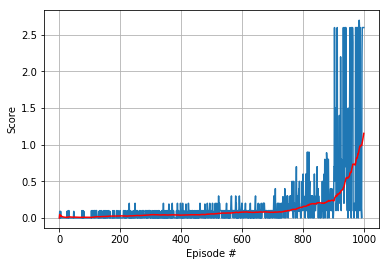

In [4]:
def state_norm(state):
    norm = np.array([10.0, 1.0, 30.0, 5.0, 10.0, 5.0, 30.0, 5.0])
    norm = np.concatenate([norm]*3)
    state_norm = state / norm
    return state_norm

def sigma_schedule(eps, score):    
    if eps < 1000:
        sigma = 1. - eps * (.9/1000)    
    else:
        sigma = 0.1 - (eps-1000) * (.05/1000)
    return sigma    

def rep_schedule(eps, score):
    if eps < 600:
        rep = 20
    elif eps < 1100:
        rep = 10
    else:
        rep = 5

    return rep
    
def ddpg(n_episodes=2000):
    scores_deque = deque(maxlen=100)
    scores = []
    mean_scores = []
    max_score = -np.Inf
    mean_score = 0.0
    for i_episode in range(1, n_episodes+1):
        states = env.reset(train_mode=True)[brain_name].vector_observations
        states = state_norm(states)
        agent.reset(sigma_schedule(i_episode, mean_score))
        agent_scores = np.zeros((num_agents))
        t = 0
        while True:
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations            
            next_states = state_norm(next_states)
            rewards = env_info.rewards
            dones = env_info.local_done
            #print(dones,rewards)
            agent.step(states, actions, rewards, next_states, dones, rep_schedule(i_episode, mean_score))
            states = next_states
            agent_scores += np.array(rewards)
            t += 1            
            if all(dones):
                break

        score = np.max(agent_scores)
        scores_deque.append(score)
        mean_score = np.mean(scores_deque)
        scores.append(score)
        mean_scores.append(np.mean(scores_deque))
        print('\rEpisode {}\tEpisode Score: {:.6f}\tAvg. Score: {:.6f}\tt: {:4}'.format(i_episode, score, mean_score, t), end="")
        if i_episode % 100 == 0:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            print('\rEpisode {}\tEpisode Score: {:.6f}\tAvg. Score: {:.6f}\tt: {:4}'.format(i_episode, score, mean_score, t))
        if np.mean(scores_deque)>=1.15:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, mean_score))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break    
    return scores, mean_scores

scores, mean_scores = ddpg(n_episodes=2000)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.plot(np.arange(1, len(scores)+1), mean_scores, 'r')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.grid()
plt.show()

In [5]:
env.close()